# Laboratorio 4

## Cargar las funciones anisotropicas

In [17]:
%run ./Anisotropic.py

## Importar librerias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
import scipy as sp
import cv2
import skimage  
import os
import random
import re
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dropout, concatenate, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import numpy as np
from tensorflow.keras.optimizers import Adam


2025-06-05 16:45:09.516158: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749167109.532420    5505 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749167109.536700    5505 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749167109.558929    5505 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749167109.558951    5505 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749167109.558953    5505 computation_placer.cc:177] computation placer alr

## Cargar las imagenes

In [13]:

def load_images(path):
    images = []
    for image in os.listdir(path):
        if image.endswith(".jpg") or image.endswith(".png") or image.endswith(".jpeg"):
            img = cv2.imread(os.path.join(path, image), cv2.IMREAD_GRAYSCALE)
            img = np.array(img, dtype=np.float32) / 255.0
            if img is not None:
                images.append(img)
    return images

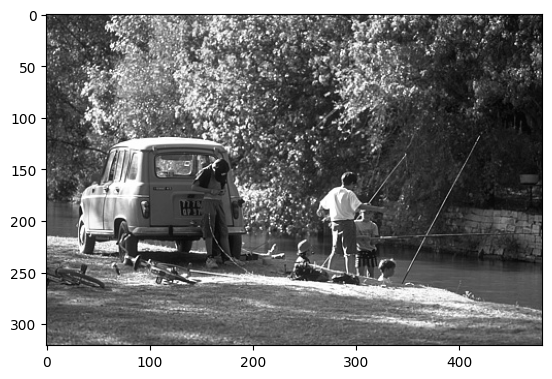

In [15]:

images = load_images(f"{os.getcwd()}/BSDS500/BSDS500/data/images/test")

plt.imshow(images[0], cmap='gray')

## Aplicar filtro anisotropico

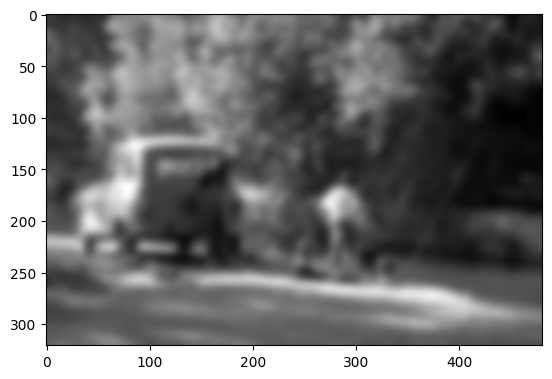

In [18]:
def apply_anisotropic_filter(image, niter=50, kappa=50, gamma=0.2, step=(1.,1.), option=1, ploton=False):
    """
    Apply anisotropic diffusion filter to an image.
    
    Parameters:
    - image: Input image (numpy array).
    - niter: Number of iterations.
    - kappa: Conductance coefficient.
    - gamma: Time step.
    - option: Option for the diffusion equation (1 or 2).
    
    Returns:
    - Filtered image.
    """
    return anisodiff(image, niter=niter, kappa=kappa, gamma=gamma, option=option)

def apply_filter_to_images(images, niter=50, kappa=50, gamma=0.2, step=(1.,1.), option=1):
    """
    Apply anisotropic diffusion filter to a list of images.
    
    Parameters:
    - images: List of input images (numpy arrays).
    - niter: Number of iterations.
    - kappa: Conductance coefficient.
    - gamma: Time step.
    - option: Option for the diffusion equation (1 or 2).
    
    Returns:
    - List of filtered images.
    """
    filtered_images = []
    for img in images:
        filtered_img = apply_anisotropic_filter(img, niter=niter, kappa=kappa, gamma=gamma, step=step, option=option)
        filtered_images.append(filtered_img)
    return filtered_images
filtered_images = apply_filter_to_images(images, niter=50, kappa=50, gamma=0.2, step=(1.,1.), option=1)

plt.imshow(filtered_images[0], cmap='gray')

## Producir coleccion de ventanas de muestra k * k

In [19]:
def extraer_ventanas_aleatorias(original_image, filtered_image, k=16, num_samples=5):
    
    h, w = original_image.shape[0], original_image.shape[1]
    x = []
    y = []
    coordenadas = set() # para evitar coordenadas repetidas
    # Asegurarse de que el número de muestras no exceda el número posible de ventanas
    max_samples = (h - k + 1) * (w - k + 1)
    if num_samples > max_samples:
        raise ValueError(f"num_samples ({num_samples}) exceeds the maximum possible windows ({max_samples}).")
    # Extraer ventanas aleatorias
    if num_samples < 1:
        raise ValueError("num_samples must be at least 1.")
    if k <= 0:
        raise ValueError("k must be a positive integer.")
    if h < k or w < k:
        raise ValueError("Image dimensions must be larger than k.")
    if not isinstance(original_image, np.ndarray) or not isinstance(filtered_image, np.ndarray):
        raise ValueError("original_image and filtered_image must be numpy arrays.")
    if original_image.shape != filtered_image.shape:
        raise ValueError("original_image and filtered_image must have the same dimensions.")
    if len(original_image.shape) != 2 or len(filtered_image.shape) != 2:
        raise ValueError("original_image and filtered_image must be 2D arrays (grayscale images).")
    if num_samples < 1 or k <= 0 or h < k or w < k:
        raise ValueError("Invalid parameters: num_samples must be at least 1, k must be a positive integer, and image dimensions must be larger than k.")
    i, j = 0, 0
    for _ in range(num_samples):
        # Asegurarse de que las coordenadas no se repitan
        while True:
            i = random.randint(0, h - k)
            j = random.randint(0, w - k)
            if (i, j) not in coordenadas:
                coordenadas.add((i, j))
                break        
        # Extraer ventanas
        xi = original_image[i:i+k, j:j+k]
        yi = filtered_image[i:i+k, j:j+k]
        
        x.append(xi)
        y.append(yi)
    
    return np.array(x), np.array(y)

def crear_base_de_datos_de_ventanas(original_images, filtered_images, k=16, num_samples=5):
    """
    Crear una base de datos de ventanas aleatorias a partir de imágenes originales y filtradas.
    
    Parameters:
    - original_images: Lista de imágenes originales (numpy arrays).
    - filtered_images: Lista de imágenes filtradas (numpy arrays).
    - k: Tamaño de la ventana.
    - num_samples: Número de muestras por imagen.
    
    Returns:
    - x: Ventanas extraídas de las imágenes originales.
    - y: Ventanas extraídas de las imágenes filtradas.
    """
    x = []
    y = []
    
    for original_image, filtered_image in zip(original_images, filtered_images):
        xi, yi = extraer_ventanas_aleatorias(original_image, filtered_image, k=k, num_samples=num_samples)
        x.append(xi)
        y.append(yi)
    
    return np.concatenate(x), np.concatenate(y)
x, y = crear_base_de_datos_de_ventanas(images[:50], filtered_images, k=64, num_samples=1000) # Son 200 ventanas por imagen 2500 * 200 = 500000 = 5*10^5
plt.imshow(x[0], cmap='gray')
plt.imshow(y[0], cmap='gray')

KeyboardInterrupt: 

## Guardar la db para que no se tenga que andar generando cada vez que se cargue el programa

In [ ]:
def save_image(image, filename):
    """
    Save an image to a file.
    
    Parameters:
    - image: Input image (numpy array).
    - filename: Name of the file to save the image.
    """
    cv2.imwrite(filename, image)
    
def save_images(original_images, filtered_images, directory):
    """
    Save a list of images to a specified directory.
    
    Parameters:
    - images: List of input images (numpy arrays).
    - directory: Directory where the images will be saved.
    """
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    for i, img in enumerate(original_images):
        save_image(
            img, 
            filename = os.path.join(directory, f'original_image_{i}.png')
            )
        save_image(
            filtered_images[i], 
            os.path.join(directory, f'filtered_image_{i}.png')
            )

save_images(x, y, f"{os.getcwd()}/data/")
# del x, y, filtered_images, images

[ WARN:0@185.122] global loadsave.cpp:848 imwrite_ Unsupported depth image for selected encoder is fallbacked to CV_8U.


## Cargar dataset

In [8]:
def load_images(path):
    original_images = []
    filtered_images = []
    for image in os.listdir(path):
        if re.search(r'original', image) and (image.endswith(".jpg") or image.endswith(".png") or image.endswith(".jpeg")):
            img = cv2.imread(os.path.join(path, image), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                original_images.append(img)
        elif re.search(r'filtered', image) and (image.endswith(".jpg") or image.endswith(".png") or image.endswith(".jpeg")):
            img = cv2.imread(os.path.join(path, image), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                filtered_images.append(img)
    return original_images, filtered_images
x, y = load_images(f"{os.getcwd()}/data/")

## Hacer tensor

In [3]:
X_train = np.array(x)
Y_train = np.array(y)

X_train = X_train[..., np.newaxis]
Y_train = Y_train[..., np.newaxis]

## Separar entre conjuntos de validacion, entrenamiento y prueba

In [4]:
def split_dataset(X, Y, val_size=0.15, test_size=0.15, random_state=42):
    """
    Crea y divide el dataset en train, validation y test
    
    Args:
        image_pairs: lista de tuplas (original, filtrada)
        k: tamaño de ventana
        N: número total de muestras
        val_size: proporción para validación
        test_size: proporción para test
        random_state: semilla para reproducibilidad
        
    Returns:
        Diccionario con los conjuntos divididos
    """
    
    # Primera división: train + temp (val + test)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, Y, 
        test_size=(val_size + test_size), 
        random_state=random_state
    )
    
    # Segunda división: val y test
    test_ratio = test_size / (val_size + test_size)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        test_size=test_ratio,
        random_state=random_state
    )
    
    return {
        'X_train': X_train,
        'y_train': y_train,
        'X_val': X_val,
        'y_val': y_val,
        'X_test': X_test,
        'y_test': y_test
    }

In [5]:
dataset = split_dataset(
    X_train,
    Y_train,
    val_size=0.15, 
    test_size=0.15
)

# Mostrar tamaños
print(f"Entrenamiento: {len(dataset['X_train'])} muestras")
print(f"Validación: {len(dataset['X_val'])} muestras")
print(f"Prueba: {len(dataset['X_test'])} muestras")

Entrenamiento: 35000 muestras
Validación: 7500 muestras
Prueba: 7500 muestras


In [9]:
del x, y

## Desarrollo de la U-Net

In [7]:
def unet_model(input_size=(32, 32, 1), num_levels=4):
    """Construye una U-Net con 3-4 niveles de profundidad"""
    
    inputs = Input(input_size, name='input')
    
    conv1 = Conv2D(64, 3, activation='relu', padding='same', name='conv1_1')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', name='conv1_2')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), name='pool1')(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', name='conv2_1')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', name='conv2_2')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), name='pool2')(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same', name='conv3_1')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', name='conv3_2')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), name='pool3')(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same', name='conv4_1')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', name='conv4_2')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2), name='pool4')(conv4)
    
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', name='conv5_1')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', name='conv5_2')(conv5)
    drop5 = Dropout(0.5, name='drop4')(conv5)
    
    up4 = UpSampling2D(size=(2, 2), name='up4')(drop5)
    merge4 = Concatenate(name='merge4')([conv4, up4])
    conv4 = Conv2D(512, 3, activation='relu', padding='same', name='conv4_3')(merge4)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', name='conv4_4')(conv4)
    
    up3 = UpSampling2D(size=(2, 2), name='up3')(conv4)
    merge3 = Concatenate(name='merge3')([conv3, up3])
    conv3 = Conv2D(256, 3, activation='relu', padding='same', name='conv3_3')(merge3)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', name='conv3_4')(conv3)
    
    up2 = UpSampling2D(size=(2, 2), name='up2')(conv3)
    merge2 = Concatenate(name='merge2')([conv2, up2])
    conv2 = Conv2D(128, 3, activation='relu', padding='same', name='conv2_3')(merge2)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', name='conv2_4')(conv2)
    
    up1 = UpSampling2D(size=(2, 2), name='up1')(conv2)
    merge1 = Concatenate(name='merge1')([conv1, up1])
    conv1 = Conv2D(64, 3, activation='relu', padding='same', name='conv1_3')(merge1)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', name='conv1_4')(conv1)
    
    output = Conv2D(1, 1, activation='linear', name='output')(conv1)
    
    model = Model(inputs=inputs, outputs=output, name='UNet')
    return model

# Create the model
model = unet_model(input_size=(64, 64, 1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse', metrics=['mae'])

# Display the model summary
model.summary()
# Callbacks
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=5),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]
history = model.fit(
    dataset['X_train'], dataset['y_train'],
    validation_data=(dataset['X_val'], dataset['y_val']),
    epochs=10,
    batch_size=32
)
# Evaluate on test set
test_loss, test_acc = model.evaluate(dataset['X_test'], dataset['y_test'], verbose=1)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc:.4f}')

I0000 00:00:1749167130.623083    5505 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1753 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 64, 64, 1) │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_1 (Conv2D)    │ (None, 64, 64,    │        640 │ input[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_2 (Conv2D)    │ (None, 64, 64,    │     36,928 │ conv1_1[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 32, 32,    │          0 │ conv1_2[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_1 (Conv2D)    │ (None, 32, 32,    │     73,856 │ pool1[0][0]       │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_2 (Conv2D)    │ (None, 32, 32,    │    147,584 │ conv2_1[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool2               │ (None, 16, 16,    │          0 │ conv2_2[0][0]     │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3_1 (Conv2D)    │ (None, 16, 16,    │    295,168 │ pool2[0][0]       │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3_2 (Conv2D)    │ (None, 16, 16,    │    590,080 │ conv3_1[0][0]     │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool3               │ (None, 8, 8, 256) │          0 │ conv3_2[0][0]     │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv4_1 (Conv2D)    │ (None, 8, 8, 512) │  1,180,160 │ pool3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv4_2 (Conv2D)    │ (None, 8, 8, 512) │  2,359,808 │ conv4_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool4               │ (None, 4, 4, 512) │          0 │ conv4_2[0][0]     │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv5_1 (Conv2D)    │ (None, 4, 4,      │  4,719,616 │ pool4[0][0]       │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv5_2 (Conv2D)    │ (None, 4, 4,      │  9,438,208 │ conv5_1[0][0]     │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ drop4 (Dropout)     │ (None, 4, 4,      │          0 │ conv5_2[0][0]     │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up4 (UpSampling2D)  │ (None, 8, 8,      │          0 │ drop4[0][0]       │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merge4              │ (None, 8, 8,      │          0 │ conv4_2[0][0],  

 Total params: 31,377,793 (119.70 MB)

 Trainable params: 31,377,793 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

2025-06-05 16:45:31.511000: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 143360000 exceeds 10% of free system memory.
2025-06-05 16:45:31.650405: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 143360000 exceeds 10% of free system memory.
2025-06-05 16:45:31.767884: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 143360000 exceeds 10% of free system memory.
2025-06-05 16:45:31.792110: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 143360000 exceeds 10% of free system memory.


Epoch 1/10


I0000 00:00:1749167135.298381    5659 service.cc:152] XLA service 0x7fac280025f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749167135.298417    5659 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2025-06-05 16:45:35.378763: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1749167135.962810    5659 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1749167150.983104    5659 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1093/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.2350 - mae: 0.4430

2025-06-05 16:48:28.735228: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 934.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1094/1094 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - loss: 0.2350 - mae: 0.4430

2025-06-05 16:48:39.695555: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 968.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-06-05 16:48:50.159851: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 883.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


1094/1094 ━━━━━━━━━━━━━━━━━━━━ 199s 164ms/step - loss: 0.2350 - mae: 0.4430 - val_loss: 0.2220 - val_mae: 0.4510
Epoch 2/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 166s 151ms/step - loss: 0.2261 - mae: 0.4496 - val_loss: 0.2214 - val_mae: 0.4348
Epoch 3/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 168s 154ms/step - loss: 0.2251 - mae: 0.4483 - val_loss: 0.2210 - val_mae: 0.4411
Epoch 4/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 169s 155ms/step - loss: 0.2240 - mae: 0.4465 - val_loss: 0.2245 - val_mae: 0.4590
Epoch 5/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 170s 155ms/step - loss: 0.2247 - mae: 0.4484 - val_loss: 0.2217 - val_mae: 0.4493
Epoch 6/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 170s 155ms/step - loss: 0.2234 - mae: 0.4462 - val_loss: 0.2213 - val_mae: 0.4433
Epoch 7/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 170s 155ms/step - loss: 0.2259 - mae: 0.4510 - val_loss: 0.2212 - val_mae: 0.4466
Epoch 8/10
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 172s 157ms/step - loss: 0.2246 - mae: 0.4484 - val_loss: 0.2215 - val_mae: 0.4348
Epoch 9/10
1094/109

## Inferencia

In [ ]:
def sliding_window_inference(model, image, window_size, stride=None):
    """Aplica inferencia usando ventana deslizante y reconstruye la imagen"""
    if stride is None:
        stride = window_size // 2  # 50% de solapamiento
    
    h, w = image.shape
    
    # Imagen de salida y contador para promedio
    output = np.zeros_like(image)
    count = np.zeros_like(image)
    
    # Deslizar ventana
    for y in range(0, h - window_size + 1, stride):
        for x in range(0, w - window_size + 1, stride):
            # Extraer ventana
            window = image[y:y+window_size, x:x+window_size]
            
            # Preparar para predicción
            window_input = window[np.newaxis, ..., np.newaxis]
            
            # Predicción
            window_pred = model.predict(window_input, verbose=0)[0, ..., 0]
            
            # Acumular en imagen de salida
            output[y:y+window_size, x:x+window_size] += window_pred
            count[y:y+window_size, x:x+window_size] += 1
    
    # Manejar bordes si no fueron cubiertos completamente
    # Bordes derecho e inferior
    if h % stride != 0:
        y = h - window_size
        for x in range(0, w - window_size + 1, stride):
            window = image[y:y+window_size, x:x+window_size]
            window_input = window[np.newaxis, ..., np.newaxis]
            window_pred = model.predict(window_input, verbose=0)[0, ..., 0]
            output[y:y+window_size, x:x+window_size] += window_pred
            count[y:y+window_size, x:x+window_size] += 1
    
    if w % stride != 0:
        x = w - window_size
        for y in range(0, h - window_size + 1, stride):
            window = image[y:y+window_size, x:x+window_size]
            window_input = window[np.newaxis, ..., np.newaxis]
            window_pred = model.predict(window_input, verbose=0)[0, ..., 0]
            output[y:y+window_size, x:x+window_size] += window_pred
            count[y:y+window_size, x:x+window_size] += 1
    
    # Esquina inferior derecha
    if h % stride != 0 and w % stride != 0:
        y, x = h - window_size, w - window_size
        window = image[y:y+window_size, x:x+window_size]
        window_input = window[np.newaxis, ..., np.newaxis]
        window_pred = model.predict(window_input, verbose=0)[0, ..., 0]
        output[y:y+window_size, x:x+window_size] += window_pred
        count[y:y+window_size, x:x+window_size] += 1
    
    # Promedio donde hay solapamientos
    count[count == 0] = 1  # Evitar división por cero
    output = output / count
    
    return output


results = []
for i, (original, filtered_gt) in enumerate(zip(images[-50:], filtered_images[-50:])):
    
    # Inferencia con U-Net
    filtered_unet = sliding_window_inference(model, original, 64)
    
    results.append({
        'original': original,
        'filtered_gt': filtered_gt,
        'filtered_unet': filtered_unet
    })